In [23]:
import pandas as pd
import numpy as np

import re

import importlib
import clean_data


importlib.reload(clean_data)
from clean_data import clean_mktcap, clean_price

## 資料匯入

In [24]:
import pandas as pd
import os

# === 設定資料夾 ===
input_folder = "merged_csvs"

# === 要匯入的變數名稱 ===
var_names = [
    "price", "mktcap", "pe_ratio", "pb_ratio", "yd",
    "beta", "earn_yoy", "gross", "rev", "eps"
]

# === 匯入 CSV 檔 ===
for name in var_names:
    file_path = os.path.join(input_folder, f"{name}.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0, encoding="utf-8-sig")

        # === 🟩 index 格式化邏輯 ===
        if name == "price":
            # ✅ 收盤價保留完整日期格式
            df.index = pd.to_datetime(df.index, errors="coerce")
            df.index.name = "date"
        else:
            # ✅ 其他變數轉成 PeriodIndex (freq='M')
            df.index = pd.to_datetime(df.index, errors="coerce").to_period("M")
            df.index.name = "month"

        # 存入全域變數
        globals()[name] = df
        print(f"✔ 已載入 {name} ({df.shape[0]} rows × {df.shape[1]} cols)")
    else:
        print(f"⚠ 找不到檔案：{file_path}")

print("\n✅ 所有指定變數已載入完成 — price 為 DatetimeIndex，其餘為 PeriodIndex(freq='M')。")


returns = price.pct_change()



#金融保險
finance_corp = pd.read_excel("因子資料全.xlsx",sheet_name="金融保險（含下市櫃）")



✔ 已載入 price (5650 rows × 506 cols)
✔ 已載入 mktcap (276 rows × 506 cols)
✔ 已載入 pe_ratio (276 rows × 506 cols)
✔ 已載入 pb_ratio (276 rows × 506 cols)
✔ 已載入 yd (276 rows × 506 cols)
✔ 已載入 beta (276 rows × 506 cols)
✔ 已載入 earn_yoy (274 rows × 506 cols)
✔ 已載入 gross (90 rows × 506 cols)
✔ 已載入 rev (90 rows × 506 cols)
✔ 已載入 eps (276 rows × 506 cols)

✅ 所有指定變數已載入完成 — price 為 DatetimeIndex，其餘為 PeriodIndex(freq='M')。


C:\Users\admin\AppData\Local\Temp\ipykernel_25500\2750205928.py:39: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



## 產出Alpha

In [25]:
import importlib
import alpha
import pe
import yeild
import revenue_growth
import eps_growth

importlib.reload(alpha)
importlib.reload(pe)
importlib.reload(yeild)
importlib.reload(revenue_growth)
importlib.reload(eps_growth)

from alpha import build_sample_pool, build_sample_pool_ex_fin,momentum_signal , pool_to_alpha ,pe_low_signal,dy_high_signal,yoy_high_signal,margin_growth_signal,eps_growth_signal,quantrend_sig, margin_surprise_signal


In [26]:
top200 = build_sample_pool(mktcap,top_n=300)
top200_nofin = build_sample_pool_ex_fin(mktcap,finance_corp)
top200_alpha = pool_to_alpha(returns, top200)

In [27]:
momentum_01_alpha = momentum_signal(returns, top200,lookback_months=1)
momentum_03_alpha = momentum_signal(returns, top200,lookback_months=3)
momentum_06_alpha = momentum_signal(returns, top200,lookback_months=6)

pe_low_01_alpha = pe_low_signal(returns, pe_ratio, top200_nofin)

pb_low_01_alpha = pe_low_signal(returns, pb_ratio, top200_nofin)

high_yield_alpha = dy_high_signal(returns, yd, top200,require_positive=False)

low_vol_alpha =  pe_low_signal(returns, beta, top200, require_positive=True)

high_yoy_alpha = yoy_high_signal(returns, earn_yoy,top200,yoy_cap_ratio=200,      # 200%
    yoy_is_percent=True,    # 你的數據是百分比
    require_positive=False  # 依你的條件，不強制 >0
)

In [28]:
sig_margin = margin_growth_signal(
    returns=returns, 
    gross=gross, 
    operating=rev, 
    mktcap_pool=top200_nofin
)

In [29]:
eps_up = eps_growth_signal(
    returns=returns,
    eps_est=eps,
    mktcap_pool=top200,
    increase_strict=True,   # 嚴格 > 才算成長
    require_positive=True   # EPS 必須為正
)

In [30]:
quantrend = quantrend_sig(
    returns=returns,
    prices=price,
    eps_est=eps,
    pe_ratio=pe_ratio,
    mktcap_pool=top200,
    n_select=20
)



In [31]:
margin_surprise = margin_surprise_signal(
    returns=returns,
    prices=price,
    margin_q=gross,   # 或 gross_margin_df，看你要用哪個
    mktcap_pool=top200,
    top_frac=0.2,
    require_positive_margin=True
)



In [32]:
def alp_return(alpha: pd.DataFrame, returns: pd.DataFrame) -> pd.Series:
    """
    給定 alpha (0/1 矩陣) 和 returns，計算每日投組報酬。
    """
    weighted_ret = (alpha * returns).sum(axis=1)
    counts = alpha.sum(axis=1)
    return (weighted_ret / counts).dropna()

######

# 2003-2025績效表現分析

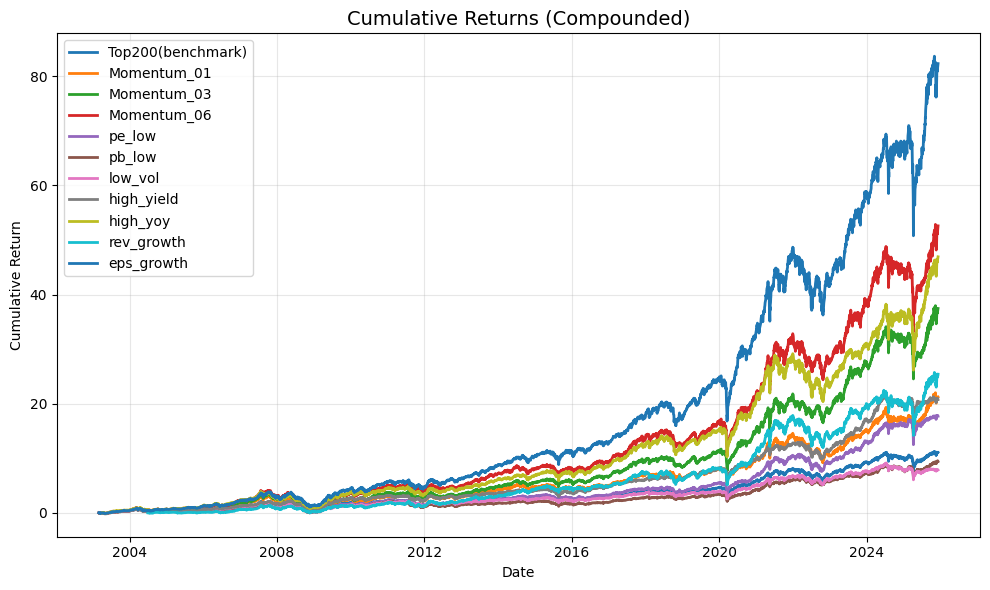

In [33]:
import matplotlib.pyplot as plt

def plot_cum_returns(*series, labels=None, title="Cumulative Returns (Compounded)"):
    """
    輸入一個或多個 return series，畫複利累積報酬
    series: 每個是 pd.Series (index=日期, values=日報酬)
    labels: 對應的名稱
    
    """
    plt.figure(figsize=(10, 6))
    
    for i, s in enumerate(series):
        cum = (1 + s).cumprod() - 1
        label = labels[i] if labels else f"Series {i+1}"
        plt.plot(cum.index, cum.values, label=label, linewidth=2)
    
    plt.title(title, fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

ret_top200 = alp_return(top200_alpha, returns)
ret_mom = alp_return(momentum_01_alpha, returns)
ret_mom3 = alp_return(momentum_03_alpha, returns)
ret_mom6 = alp_return(momentum_06_alpha, returns)
ret_pe_low1 = alp_return(pe_low_01_alpha, returns)
ret_pb_low1 = alp_return(pb_low_01_alpha, returns)
ret_low_vol = alp_return(low_vol_alpha, returns)
ret_high_yield = alp_return(high_yield_alpha,returns)
ret_high_yoy = alp_return(high_yoy_alpha,returns) #lag兩個月
ret_rev_growth = alp_return(sig_margin,returns)
ret_eps_growth = alp_return(eps_up,returns)

plot_cum_returns(ret_top200, ret_mom,ret_mom3,ret_mom6,ret_pe_low1,ret_pb_low1,ret_low_vol,ret_high_yield,ret_high_yoy,ret_rev_growth,ret_eps_growth,labels=["Top200(benchmark)", "Momentum_01","Momentum_03","Momentum_06","pe_low","pb_low","low_vol","high_yield","high_yoy","rev_growth","eps_growth"])


In [34]:
import pandas as pd
import numpy as np

def perf_summary(returns_dict: dict, freq: int = 252, rf: float = 0.0) -> pd.DataFrame:
    """
    統整策略績效：年化報酬、年化波動率、Sharpe ratio
    
    returns_dict: dict[str, pd.Series] {策略名稱: 日報酬序列}
    freq: 一年交易日數 (預設 252)
    rf: 無風險利率 (日化)，預設 0
    
    回傳：pd.DataFrame
    """
    rows = []
    for name, r in returns_dict.items():
        r = r.dropna()
        ann_ret = (1 + r).prod() ** (freq / len(r)) - 1
        ann_vol = r.std() * np.sqrt(freq)
        sharpe = (ann_ret - rf) / ann_vol if ann_vol > 0 else np.nan
        rows.append([ann_ret, ann_vol, sharpe])
    
    return pd.DataFrame(rows, index=returns_dict.keys(),
                        columns=["Annual Return", "Annual Volatility", "Sharpe Ratio"])

# ---------------- 使用範例 ----------------
perf_table = perf_summary({
    "Momentum_01": ret_mom,
    "Momentum_03": ret_mom3,
    "Momentum_06": ret_mom6,
    "PE_low": ret_pe_low1,
    "PB_low": ret_pb_low1,
    "Low_vol": ret_low_vol,
    "High_yield": ret_high_yield,
    "High_yoy": ret_high_yoy,
    "Rev_growth": ret_rev_growth,
    "eps_growth": ret_eps_growth,

    "benchmark":ret_top200
})

perf_table.sort_values(by="Annual Return")


,Annual Return,Annual Volatility,Sharpe Ratio
Low_vol,0.102997,0.183038,0.562708
PB_low,0.111015,0.200595,0.553430
benchmark,0.118451,0.191709,0.617865
PE_low,0.140531,0.197356,0.712071
High_yield,0.148318,0.172484,0.859897
Momentum_01,0.149381,0.206598,0.723053
Rev_growth,0.169141,0.223944,0.755283
Momentum_03,0.177977,0.210872,0.844004
High_yoy,0.190446,0.208599,0.912976
Momentum_06,0.195652,0.215309,0.908703


In [35]:
import interval_report
importlib.reload(interval_report)

from interval_report import perf_report,factor_monthly_heatmap_plotly,factor_rank_tile,factor_rank_tile_full

## 函數1:指定區間因子報酬報表

c:\Users\admin\Desktop\----_ver1\interval_report.py:61: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



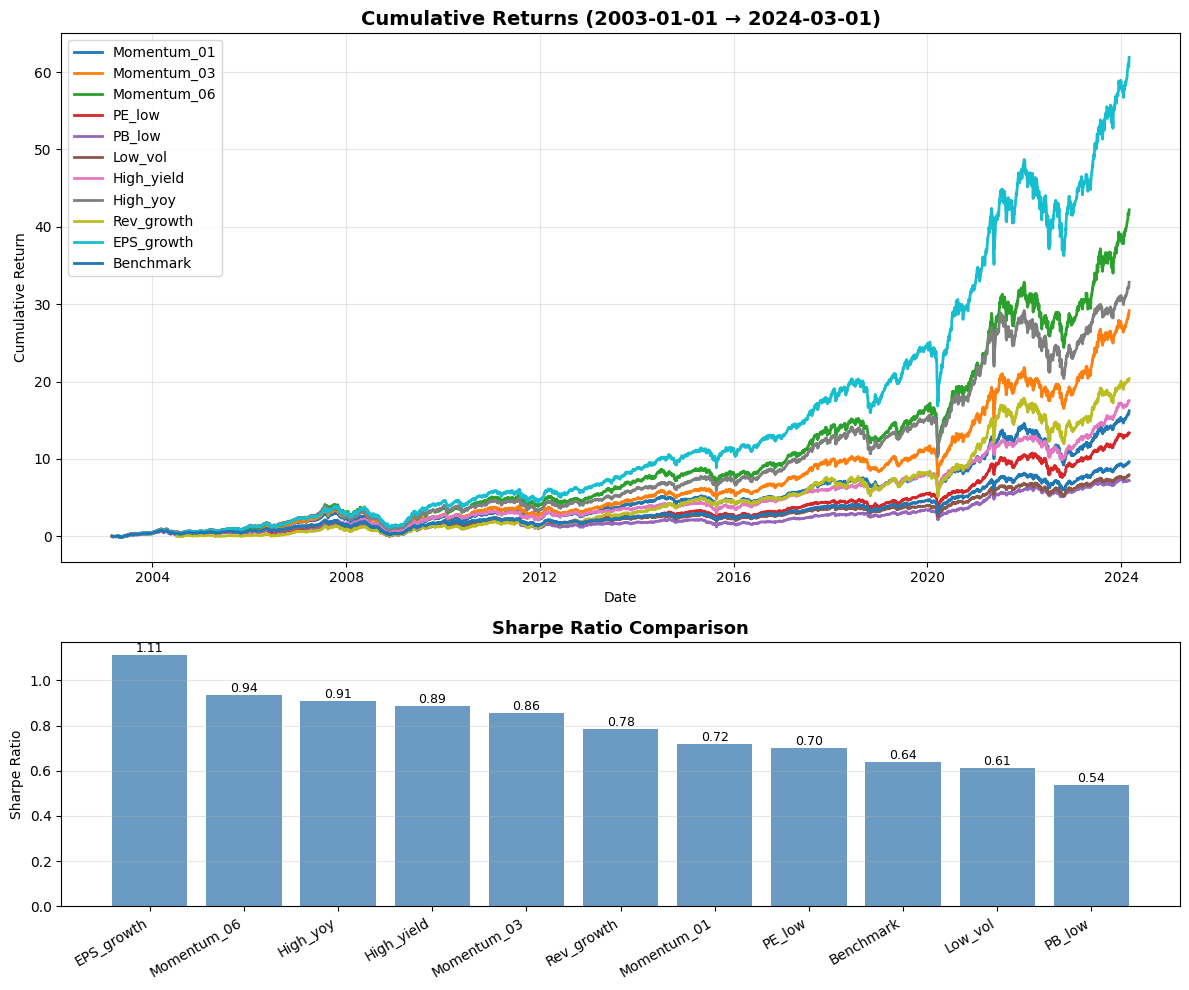

             Annual Return  Annual Volatility  Sharpe Ratio  Total Return
Momentum_01         0.1485             0.2062        0.7201       16.2251
Momentum_03         0.1802             0.2102        0.8575       29.1660
Momentum_06         0.2010             0.2144        0.9375       42.1949
PE_low              0.1384             0.1974        0.7013       13.3787
PB_low              0.1079             0.2008        0.5371        7.2157
Low_vol             0.1125             0.1831        0.6142        7.9445
High_yield          0.1526             0.1718        0.8877       17.5252
High_yoy            0.1877             0.2060        0.9110       32.8378
Rev_growth          0.1726             0.2200        0.7846       20.3615
EPS_growth          0.2232             0.2004        1.1138       61.8967
Benchmark           0.1218             0.1906        0.6392        9.6292


In [36]:
factors = {
    "Momentum_01": ret_mom,
    "Momentum_03": ret_mom3,
    "Momentum_06": ret_mom6,
    "PE_low": ret_pe_low1,
    "PB_low": ret_pb_low1,
    "Low_vol": ret_low_vol,
    "High_yield": ret_high_yield,
    "High_yoy": ret_high_yoy,
    "Rev_growth": ret_rev_growth,
    "EPS_growth": ret_eps_growth,
    "Benchmark" : ret_top200
}


start= "2003-01-01"
end= "2024-03-01"

# start= "2021-01-01"
# end= "2025-05-01"


report = perf_report(factors, start_date=start, end_date=end)
print(report.round(4))


c:\Users\admin\Desktop\----_ver1\interval_report.py:61: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



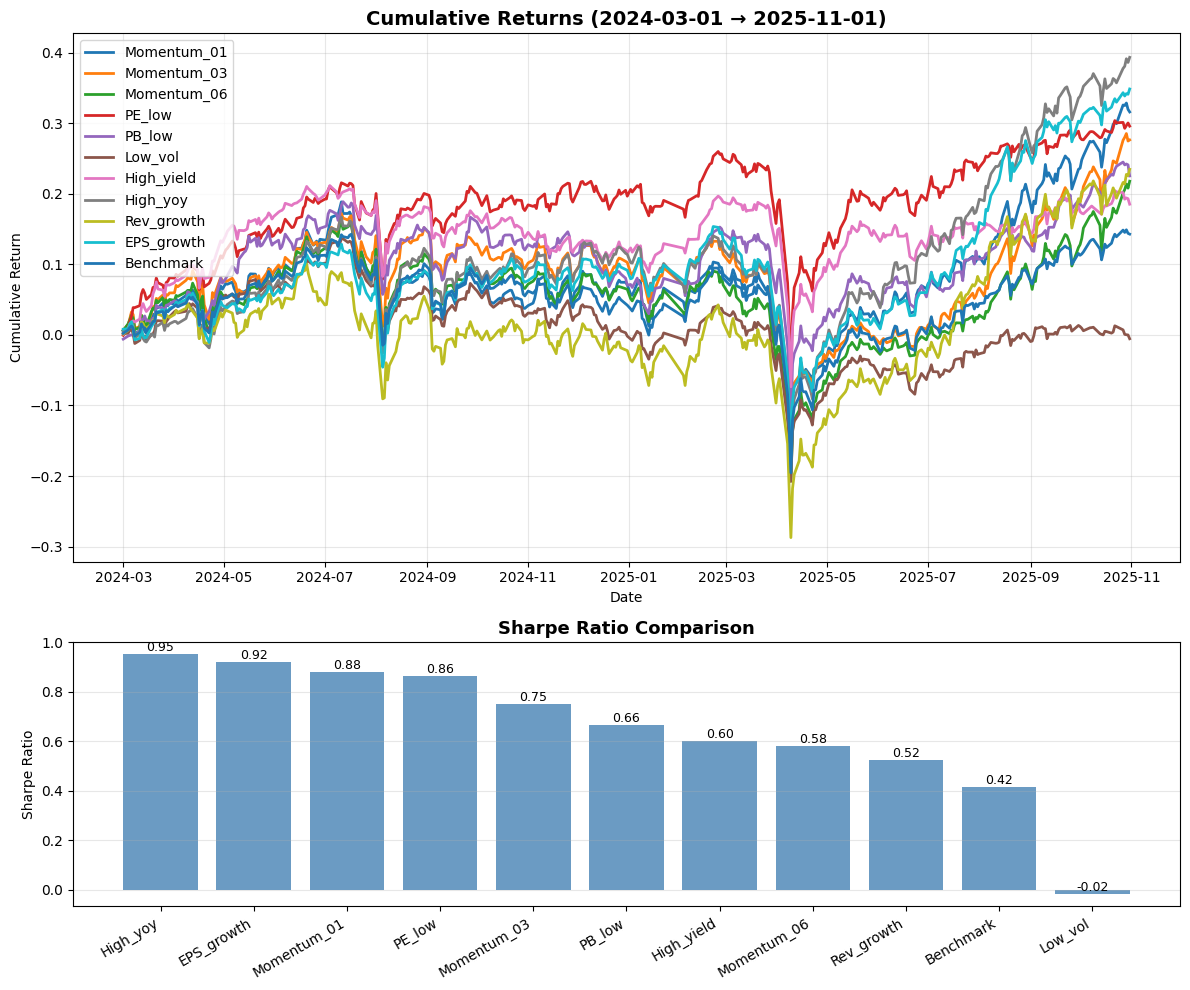

             Annual Return  Annual Volatility  Sharpe Ratio  Total Return
Momentum_01         0.1849             0.2094        0.8826        0.3160
Momentum_03         0.1627             0.2162        0.7524        0.2763
Momentum_06         0.1294             0.2222        0.5826        0.2178
PE_low              0.1736             0.2009        0.8641        0.2959
PB_low              0.1337             0.2012        0.6648        0.2253
Low_vol            -0.0034             0.1861       -0.0181       -0.0054
High_yield          0.1107             0.1835        0.6032        0.1853
High_yoy            0.2274             0.2387        0.9526        0.3934
Rev_growth          0.1391             0.2654        0.5240        0.2347
EPS_growth          0.2029             0.2200        0.9223        0.3486
Benchmark           0.0860             0.2069        0.4156        0.1429


In [37]:
factors = {
    "Momentum_01": ret_mom,
    "Momentum_03": ret_mom3,
    "Momentum_06": ret_mom6,
    "PE_low": ret_pe_low1,
    "PB_low": ret_pb_low1,
    "Low_vol": ret_low_vol,
    "High_yield": ret_high_yield,
    "High_yoy": ret_high_yoy,
    "Rev_growth": ret_rev_growth,
    "EPS_growth": ret_eps_growth,
    "Benchmark" : ret_top200
}


start= "2024-03-01"
end= "2025-11-01"

# start= "2021-01-01"
# end= "2025-05-01"


report = perf_report(factors, start_date=start, end_date=end)
print(report.round(4))

## 函數2:最近一年因子月表現熱力圖

In [38]:
returns_dict = {
    "Momentum_01": ret_mom,
    
    "Momentum_06": ret_mom6,
    "PE_low": ret_pe_low1,
    "PB_low": ret_pb_low1,
    "Low_vol": ret_low_vol,
    "High_yield": ret_high_yield,
    "High_yoy": ret_high_yoy,
    "Rev_growth": ret_rev_growth,
    "EPS_growth": ret_eps_growth,
    
}

_ = factor_rank_tile_full(
    returns_dict=returns_dict,
    periods=12,
    freq="M",                   # "M" / "W" / "Y"
    
    text_size=8,              
    # save_html="factor_rank_last12_months.html",
)


c:\Users\admin\Desktop\----_ver1\interval_report.py:312: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\admin\Desktop\----_ver1\interval_report.py:312: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\admin\Desktop\----_ver1\interval_report.py:312: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\admin\Desktop\----_ver1\interval_report.py:312: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\admin\Desktop\----_ver1\interval_report.py:312: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\admin\Desktop\----_ver1\interval_report.py:312: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\admin\Desktop\----_ver1\interval_report.py:

##### 

In [39]:
# internship、project detail，including github clear

# come up with reasearch plan

# grad school course plan

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ email to prof manager

# motivation 

# conclusion 





# 函數3: 當日持股明細

In [40]:
def porfolio_list(alpha,date):
    return alpha.columns[(alpha.loc[date]==1)]

In [41]:
(porfolio_list(pe_low_01_alpha,"2025-01-20"))

Index(['1102', '1210', '1808', '2006', '2101', '2201', '2204', '2206', '2211',
       '2303', '2327', '2347', '2357', '2371', '2385', '2474', '2504', '2603',
       '2606', '2609', '2610', '2615', '2618', '2637', '2809', '2812', '2834',
       '2855', '2881', '2882', '2883', '2885', '2887', '2888', '2890', '2891',
       '2915', '3005', '3044', '3406', '4938', '4958', '5483', '5871', '5903',
       '6005', '6121', '6147', '6176', '6239', '6412', '6488', '6605', '6670',
       '9904', '9941', '9945'],
      dtype='object')

# 函數4: 投資組合貢獻最多的個股

In [42]:
from portfo_analysis import top_contributors_report

In [43]:



def porfolio_list_period(alpha,start,end,num=30):
    selected_days = alpha.loc[start:end].sum(axis=0)
    t = selected_days.sort_values(ascending=False).head(num).index
    tickers = t
    stats_df, port_ret = top_contributors_report(
        returns, tickers, start_date=start, end_date=end, top_n=10
    )
    return stats_df





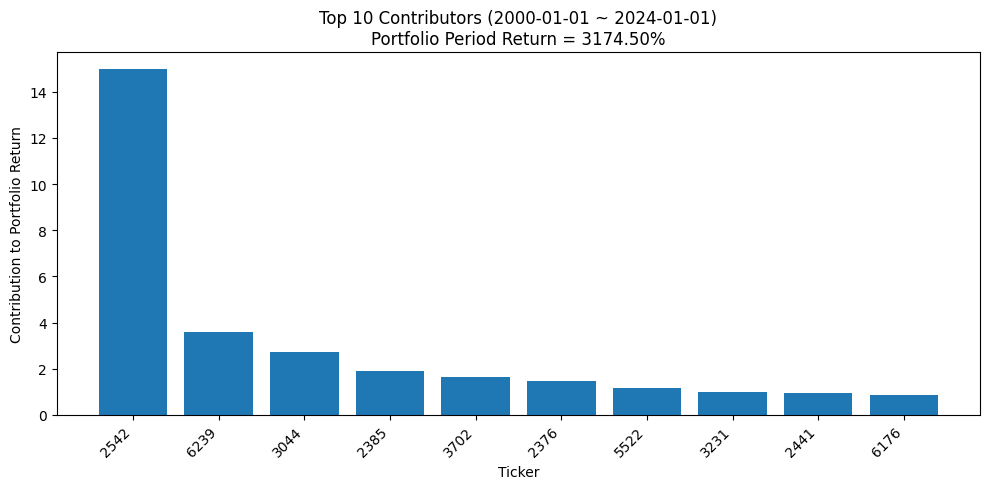

,Annual Return,Annual Volatility,Sharpe Ratio,Period Return,Weight,Contribution
2542,0.399135,0.381079,1.047380,224.562500,0.066667,14.970833
6239,0.298105,0.358206,0.832216,53.773504,0.066667,3.584900
3044,0.283294,0.368206,0.769391,41.058275,0.066667,2.737218
2385,0.238077,0.314726,0.756458,28.234637,0.066667,1.882309
3702,0.260175,0.311179,0.836094,24.702055,0.066667,1.646804
2376,0.245052,0.367313,0.667147,21.740236,0.066667,1.449349
5522,0.222951,0.348067,0.640539,17.134483,0.066667,1.142299
3231,0.225339,0.360703,0.624722,14.804754,0.066667,0.986984
2441,0.189356,0.284198,0.666284,14.422572,0.066667,0.961505
6176,0.223885,0.387167,0.578266,12.629200,0.066667,0.841947


In [44]:
porfolio_list_period(pe_low_01_alpha,"2000-01-01","2024-01-01",num=15)